## Configuration for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !pip install JSAnimation==0.1
    !pip install pyglet==1.3.2
    
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 07. Behavior Cloning (without HER)

[A. Nair et al., "Overcoming Exploration in Reinforcement Learning with Demonstrations." arXiv preprint arXiv:1709.10089, 2017.](https://arxiv.org/pdf/1709.10089.pdf)

Exploration in environments with sparse rewards has been a persistent problem in reinforcement learning. Many tasks are natural to  specify with a sparse reward, and manually shaping a reward function can result in suboptimal performance. However, finding a non-zero reward is exponentially more difficult with increasing task horizon or action dimensionality. In  this  paper, the authors use demonstrations to overcome the exploration problem and successfully learn to perform long-horizon, multi-step tasks with continuous control such as stacking blocks with a robot arm.

### DDPG
For learning in high-dimentional and continous action spaces, the authors of DDPG combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). Please see *03.DDPG.ipynb* for detailed description of DDPG.

### Demonstration Buffer
It maintains a second replay buffer $R_D$ where we store our the demonstration data in the same format as the original replay buffer $R$. In each minibatch, we draw an extra $N_D$ examples from $R_D$ to use as off-policy replay data for the update step. These examples are included in both the actor and critic update.

### Behavior Cloning Loss
It computes only on the demonstration examples for training the actor.
$$
L_{BC} = \underset{i=1}{\overset{N_D}\sum} \lVert \pi (s_i | \theta_\pi) - a_i \rVert^2
$$
This loss is a standard loss in imitation learning, but this paper shows that using it as an auxiliary loss for RL improves learning significantly. The gradient applied to the actor parameters $\theta_\pi$ is:
$$
L_A = - \lambda_1 \nabla_{\theta_{\pi}}J + \lambda_2 \nabla_{\theta_{\pi}} L_{BC}
$$
Two parameters called  $\lambda_1$ ,  $\lambda_2$  are used to weight the contributions.

### Q-Filter
Using above loss prevents the learned policy from improving significantly beyond the demonstration policy, as the actor is always tied back to the demonstrations. To avoid this problem, the authors apply the behavior cloning loss only to states where the critic $Q(s,a)$ determines that the demonstratior action is better than actor action:
$$
L_{BC} = \underset{i=1}{\overset{N_D}\sum}\lVert \pi (s_i | \theta_\pi) - a_i \rVert^2 \mathbb{1}_{Q(s_i, a_i) > Q(s_i, \pi(s_i))}
$$

### Hindsight Experience Replay (HER)
The key insight of HER is that even in failed rollouts where no reward was obtained, the agent can transform them into successful ones by assuming that a state it saw in the rollout was the actual goal. It can be used with any off-policy RL algorithm assuming that for every state we can find a goal corresponding to this state.
However, it needs parametrized goals setting, which can be sampled the goal $g$ at the beggining of every epiosde, so **we don't implement it**. Please see [this paper](https://arxiv.org/pdf/1707.01495) for detailed contents.

## Import modules

In [2]:
import os
import copy
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output

if IN_COLAB and not os.path.exists("demo.pkl"):
    # download demo.pkl
    !wget https://raw.githubusercontent.com/mrsyee/pg-is-all-you-need/master/demo.pkl

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

In addition, we add `extend` method to store multi transitions like demonstration.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initialize."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def extend(
        self, 
        transitions: List[Tuple],
    ):
        """Store the multi transitions in buffer."""
        for transition in transitions:
            self.store(*transition)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## OU Noise
*Ornstein-Uhlenbeck* process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference: 
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [4]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

## Network
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, *ReLU* for hidden layers and *tanh* for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers *ReLU*. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are *uniformly distributed.*

In [5]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()
        
        return action
    
    
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

## BC Agent
Here is a summary of Agent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_plot              | plot the training progresses.                        |
|\_target_soft_update| soft update from the local model to the target model.|

In [6]:
class BCAgent:
    """BCAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        demo_memory (ReplayBuffer): replay memory for demonstration
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        lambda1 (float): weight for policy gradient loss
        lambda2 (float): weight for behavior cloning loss
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        demo_batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        demo: list,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
        # loss parameters
        lambda1: float = 1e-3,
        lambda2: int = 1.0
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        
        # loss parameters
        self.lambda1 = lambda1
        self.lambda2 = lambda2 / demo_batch_size

        # buffer
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size) 
        
        # demo buffer
        self.demo_memory = ReplayBuffer(obs_dim, len(demo), demo_batch_size)
        self.demo_memory.extend(demo) 
            
        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()
        
        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        # sample from replay buffer
        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # sample from demo buffer
        d_samples = self.demo_memory.sample_batch()
        d_state = torch.FloatTensor(d_samples["obs"]).to(device)
        d_next_state = torch.FloatTensor(d_samples["next_obs"]).to(device)
        d_action = torch.FloatTensor(d_samples["acts"].reshape(-1, 1)).to(device)
        d_reward = torch.FloatTensor(d_samples["rews"].reshape(-1, 1)).to(device)
        d_done = torch.FloatTensor(d_samples["done"].reshape(-1, 1)).to(device)        
        
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        curr_return = curr_return.to(device).detach()
        
        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
                
        # train actor
        # PG loss
        pg_loss = -self.critic(state, self.actor(state)).mean()
    
        # BC loss
        pred_action = self.actor(d_state)       
        qf_mask = torch.gt(
            self.critic(d_state, d_action),
            self.critic(d_state, pred_action),
        ).to(device)
        qf_mask = qf_mask.float()
        n_qf_mask = int(qf_mask.sum().item())
        
        if n_qf_mask == 0:
            bc_loss = torch.zeros(1, device=device)
        else:
            bc_loss = (
                torch.mul(pred_action, qf_mask) - torch.mul(d_action, qf_mask)
            ).pow(2).sum() / n_qf_mask
            
        actor_loss = self.lambda1 * pg_loss + self.lambda2 * bc_loss
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # target update
        self._target_soft_update()
        
        return actor_loss.data, critic_loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:         
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
            
            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step, 
                    scores, 
                    actor_losses, 
                    critic_losses,
                )
                
        self.env.close()
        
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [7]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [8]:
# environment
env_id = "Pendulum-v0"
env = gym.make(env_id)
env = ActionNormalizer(env)

## Set random seed

In [9]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

[777]

## Initialize
We make the demonstration using the well-trained agent in advance. (The given demo.pkl is created using *03.DDPG* agent.)

In [10]:
import pickle

# load demo on replay memory
demo_path = "demo.pkl"
with open(demo_path, "rb") as f:
    demo = pickle.load(f)

In [11]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 1024
demo_batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

agent = BCAgent(
    env, 
    memory_size, 
    batch_size,
    demo_batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    demo,
    initial_random_steps=initial_random_steps,
)

cpu


## Train

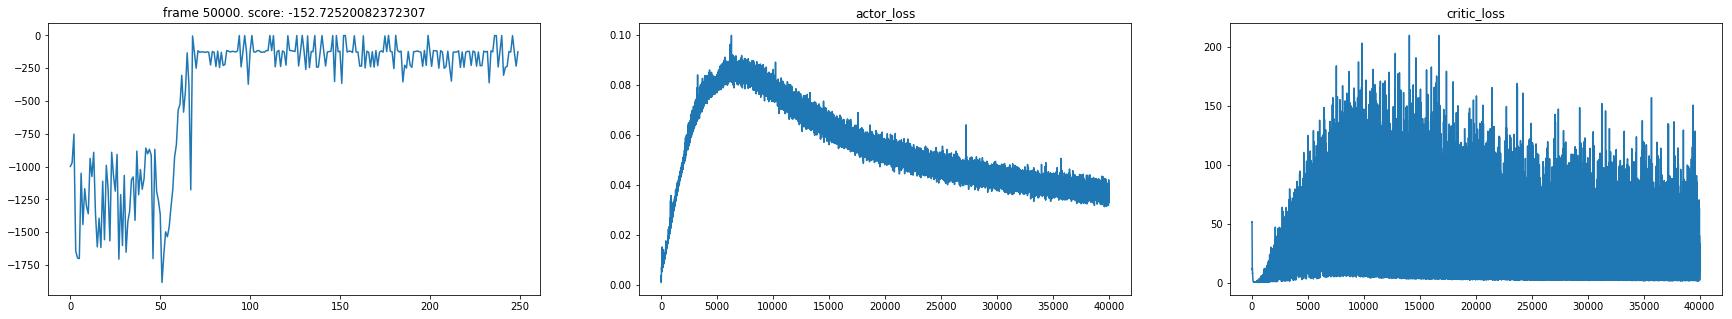

In [12]:
agent.train(num_frames)

## Test
Run the trained agent (1 episode).

In [13]:
frames = agent.test()

score:  -241.61051085499938


## Render


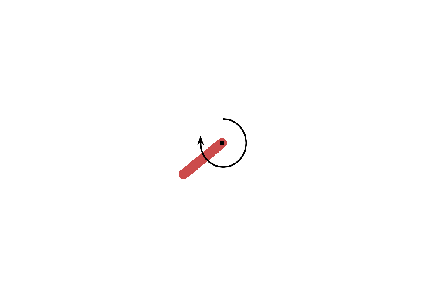
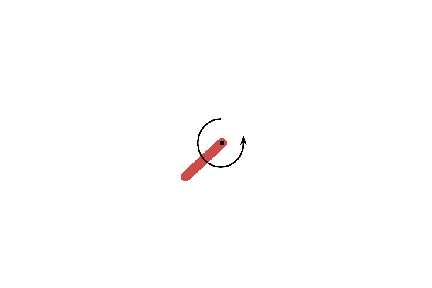
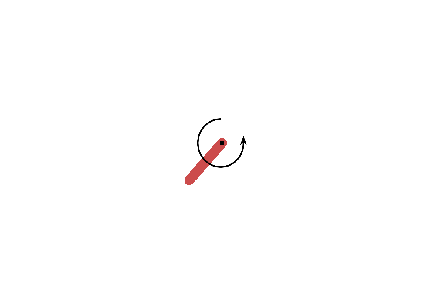
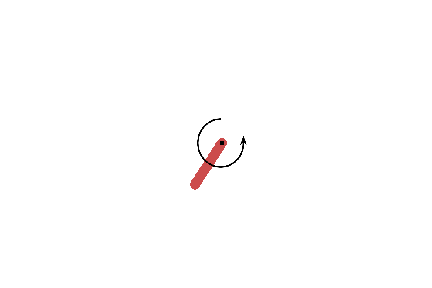
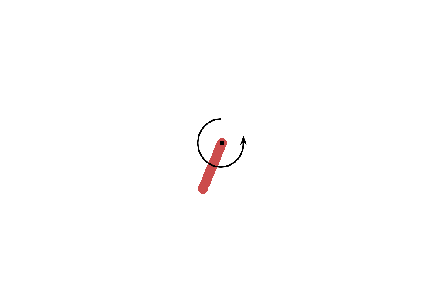
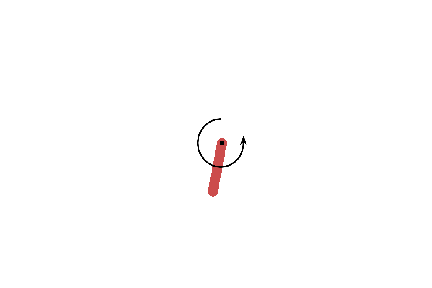
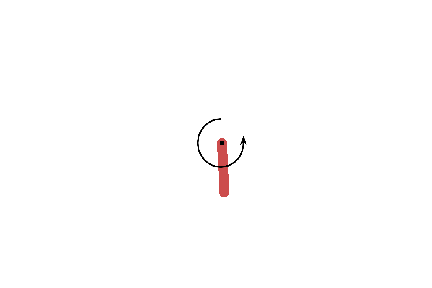
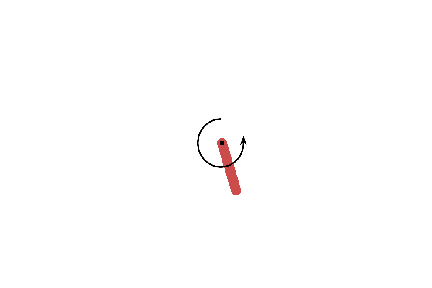
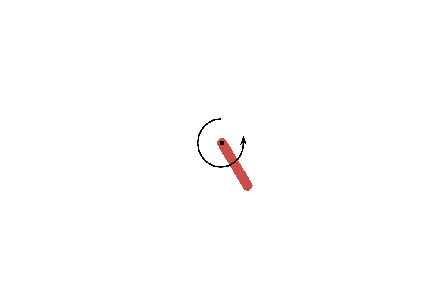
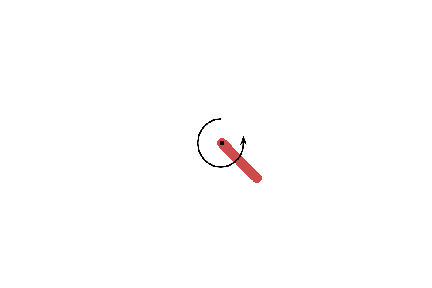
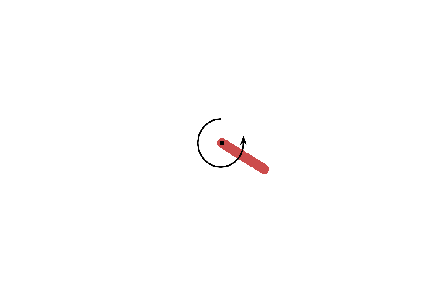
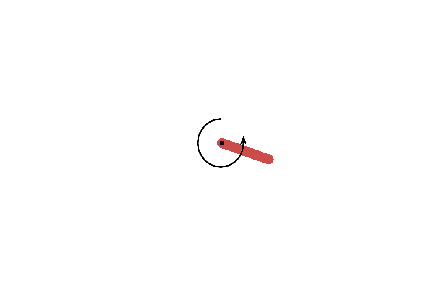
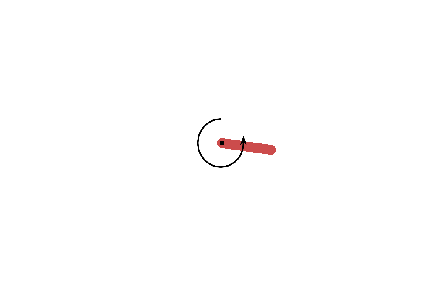
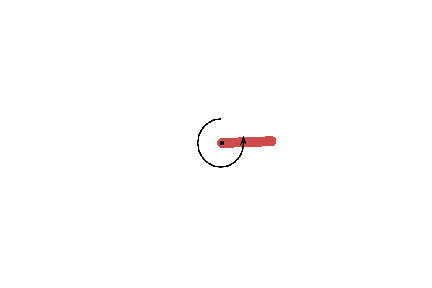
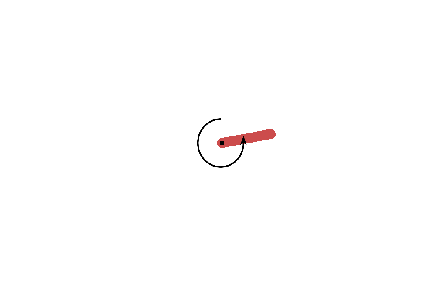
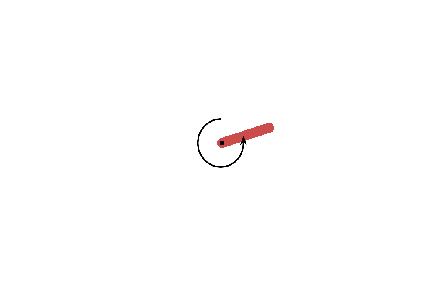
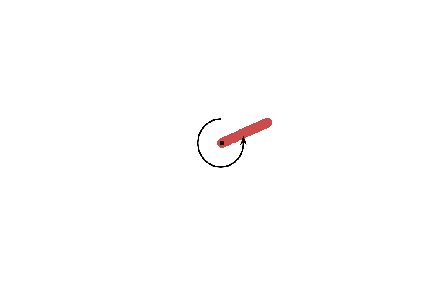
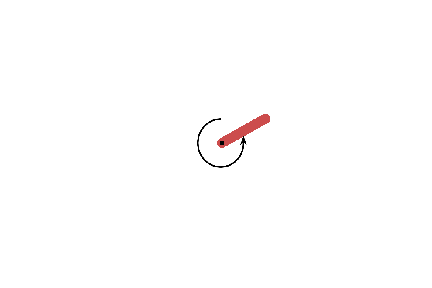
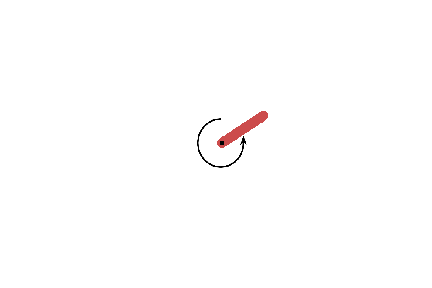
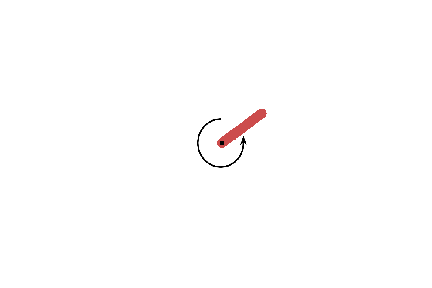
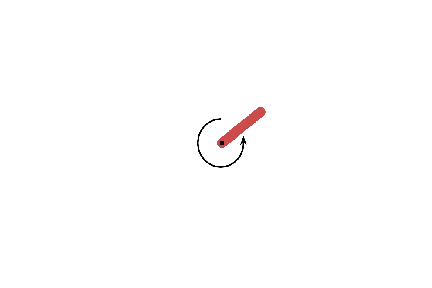
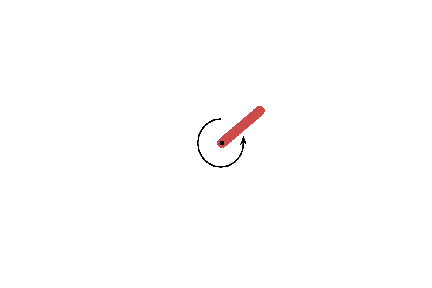
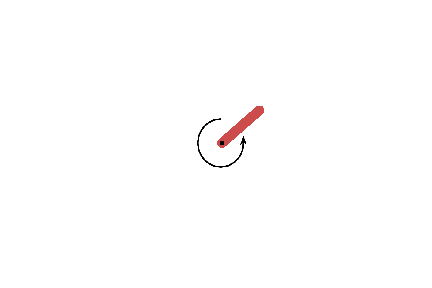
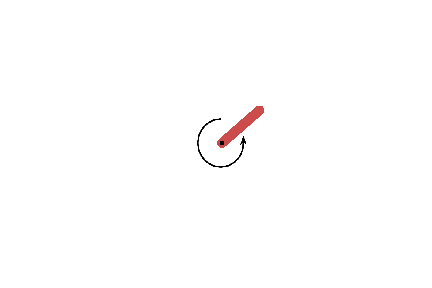
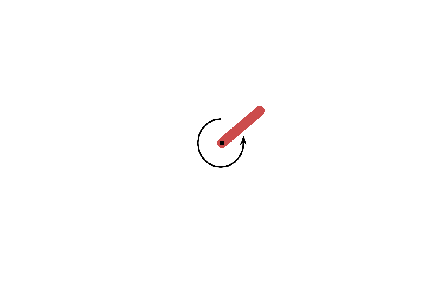
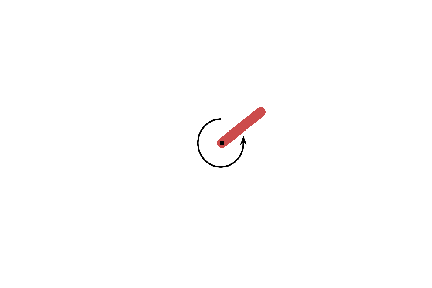
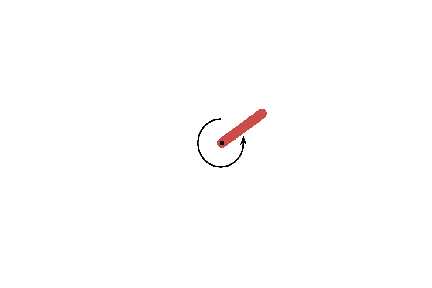
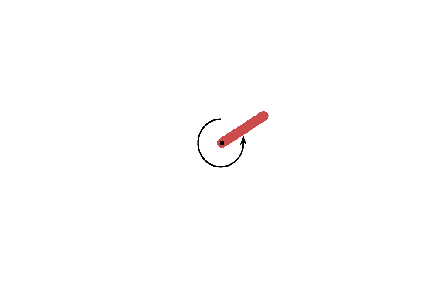
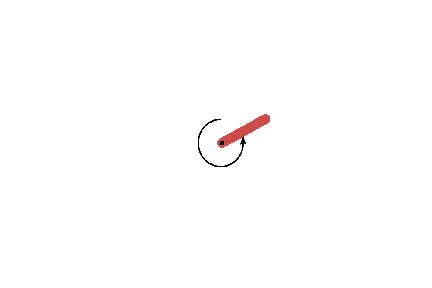
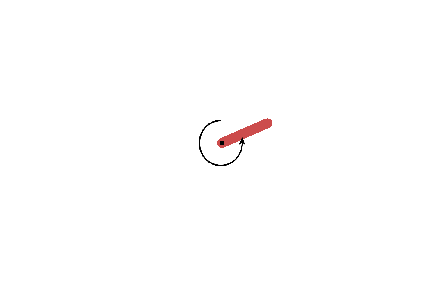
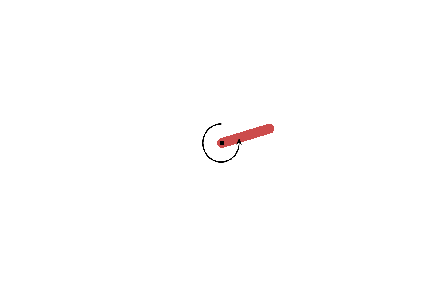
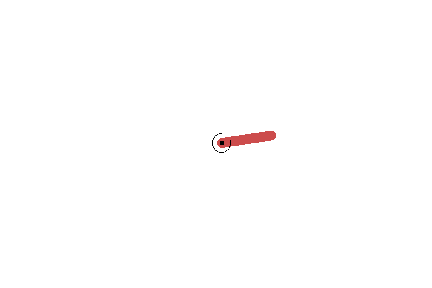
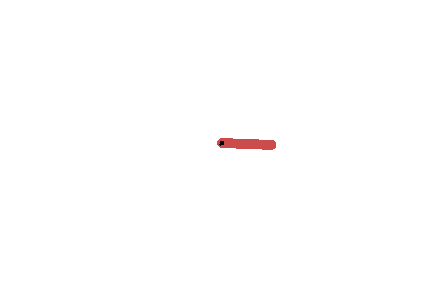
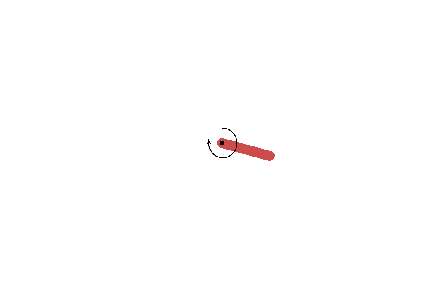
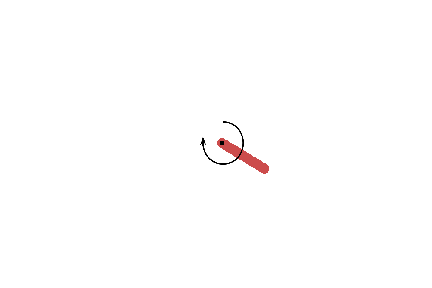
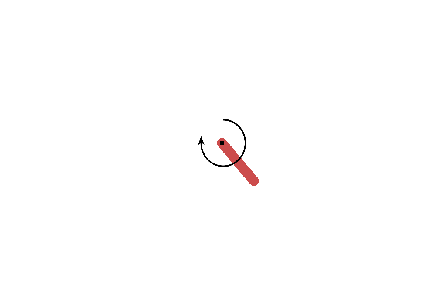
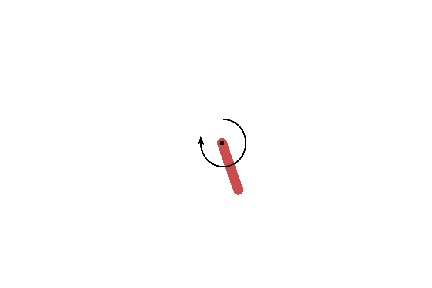
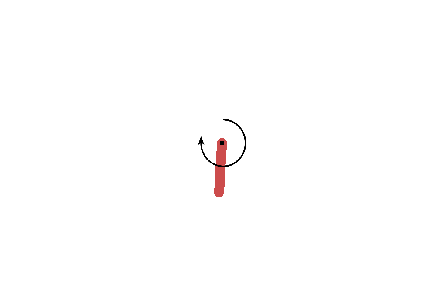
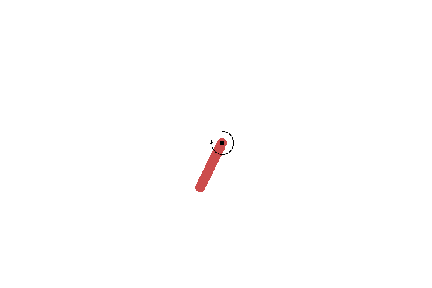
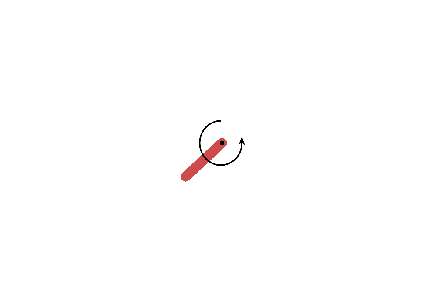
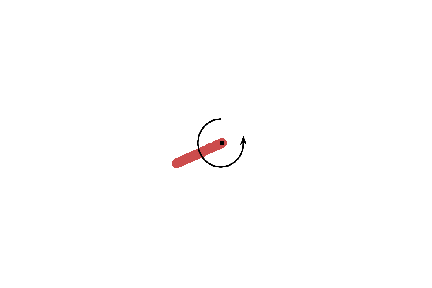
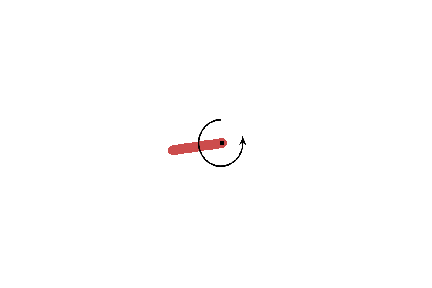
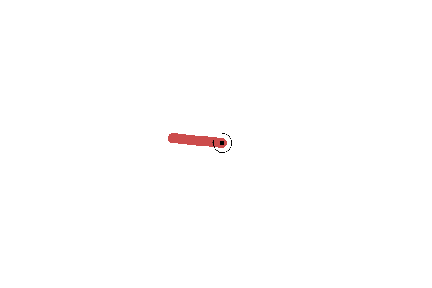
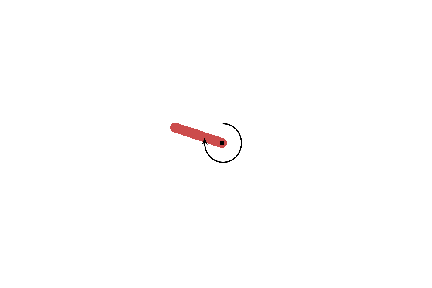
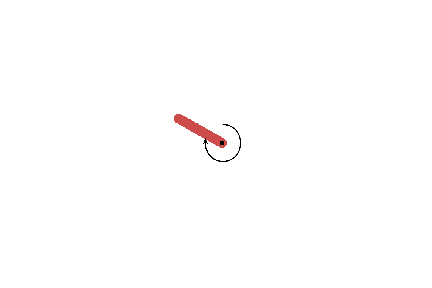
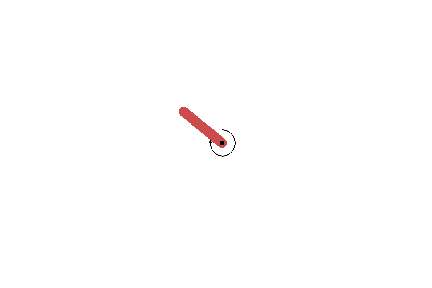
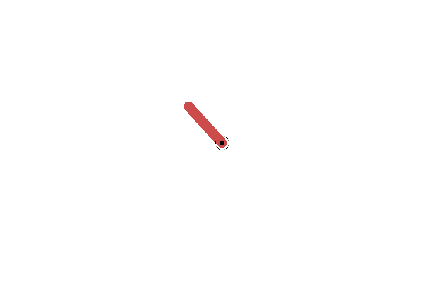
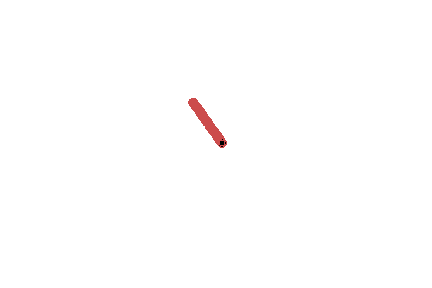
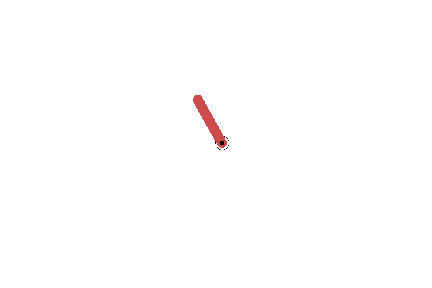
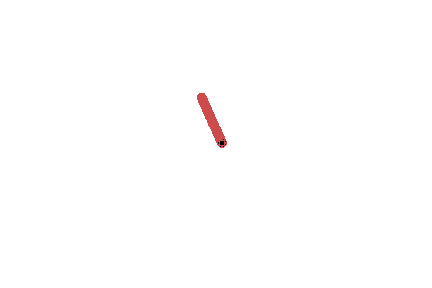
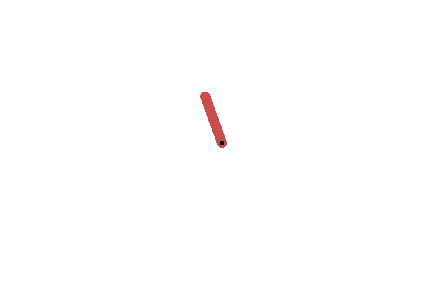
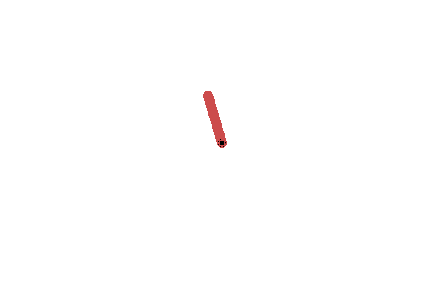
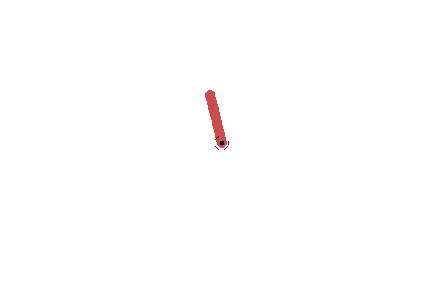
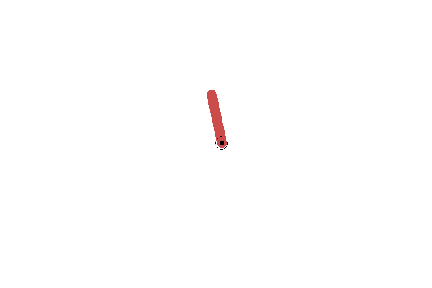
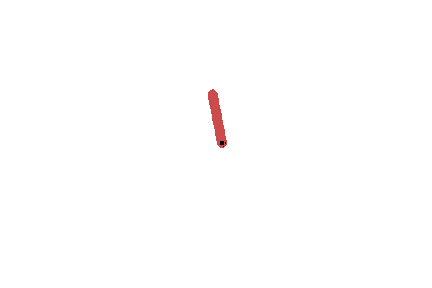
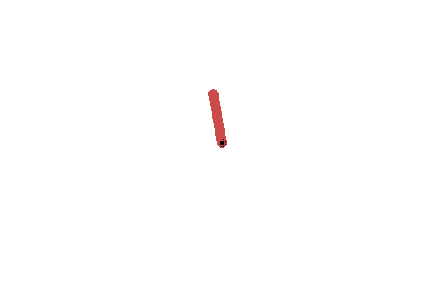
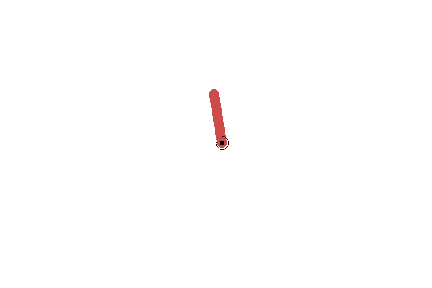
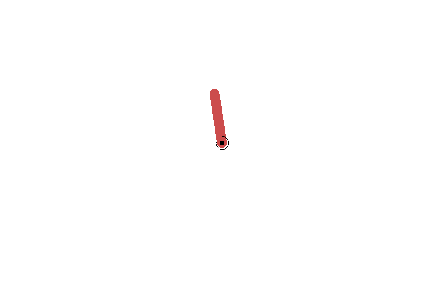
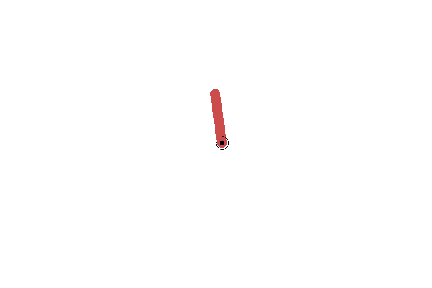
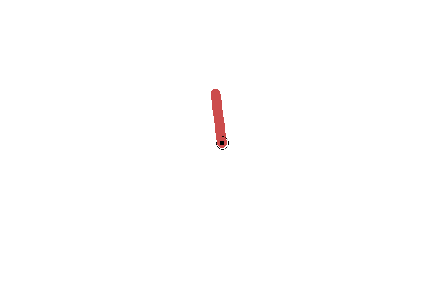
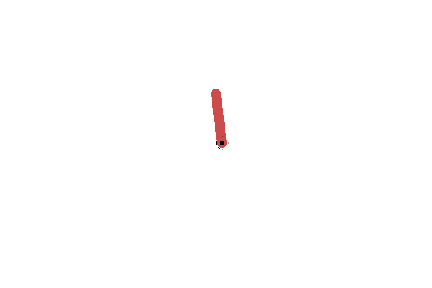
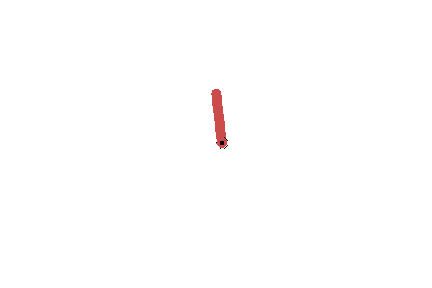
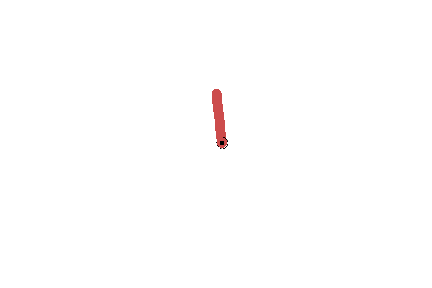
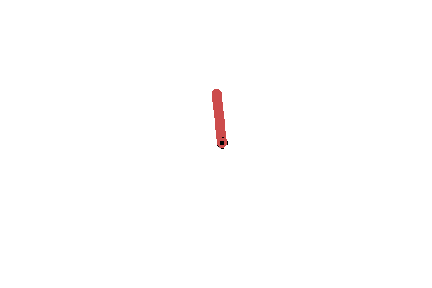
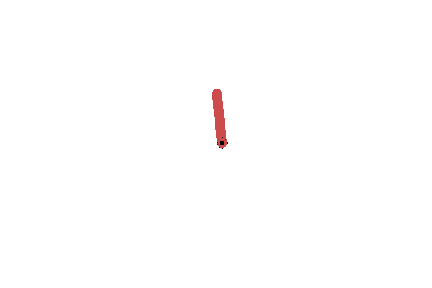
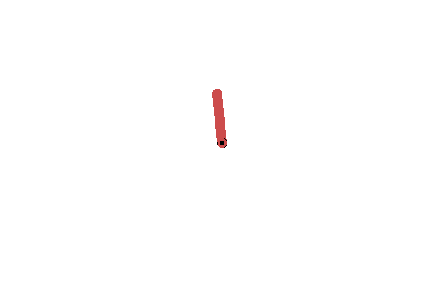
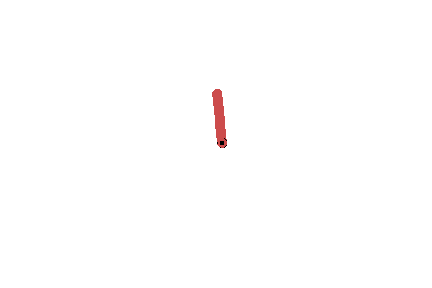
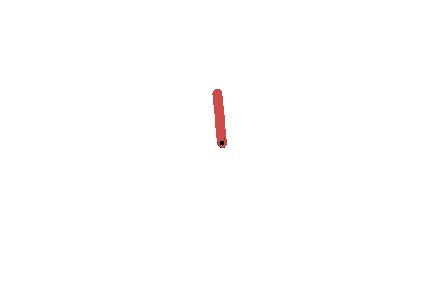
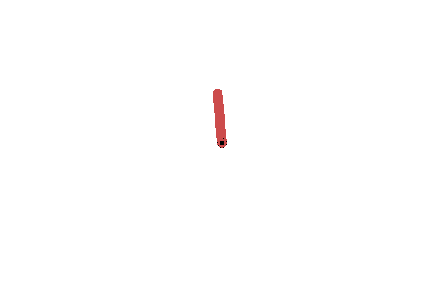
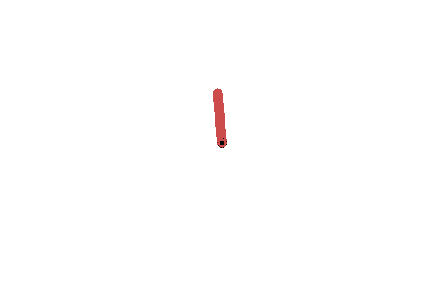
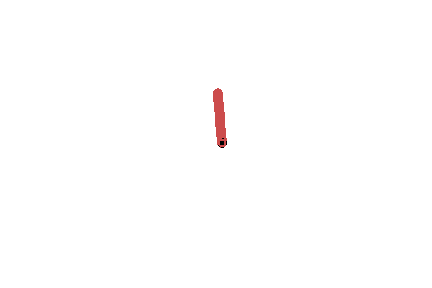
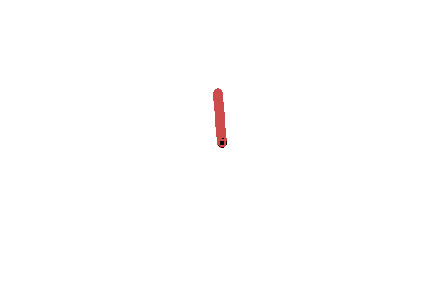
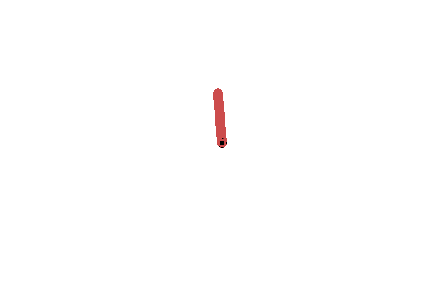
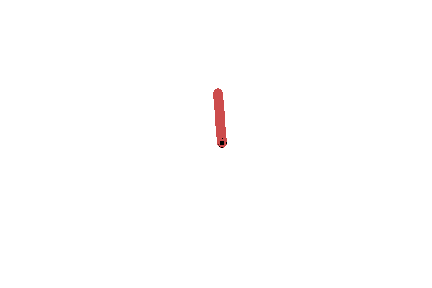
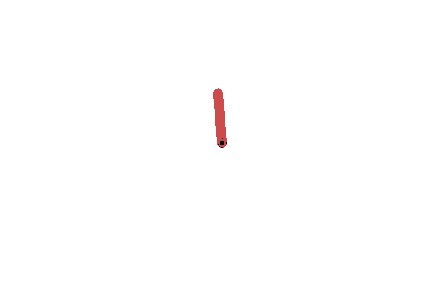
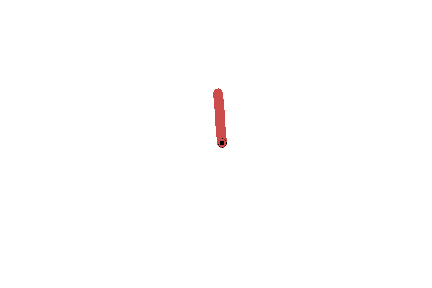
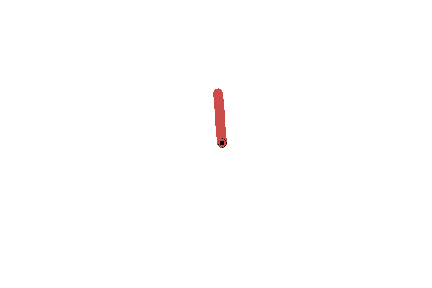
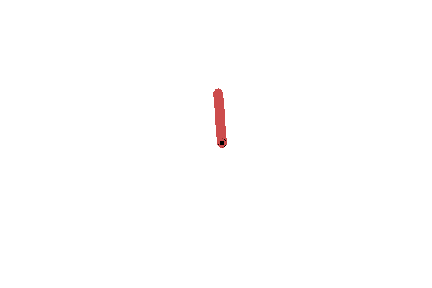
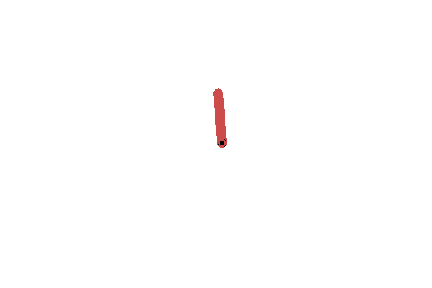
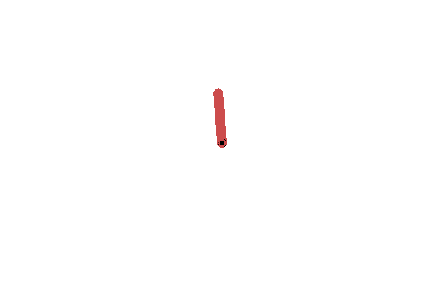
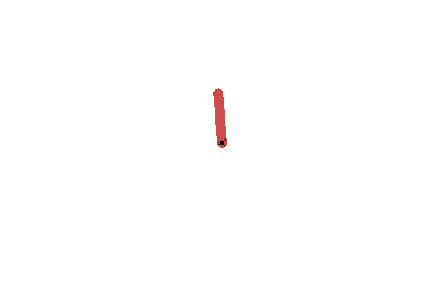
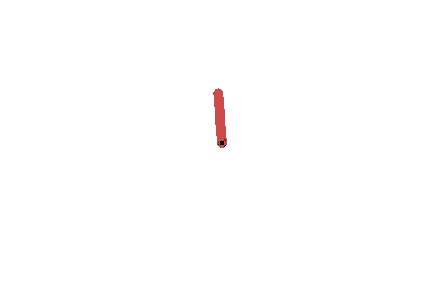
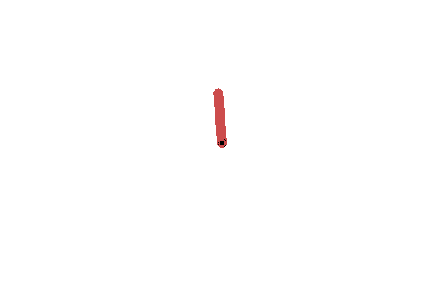
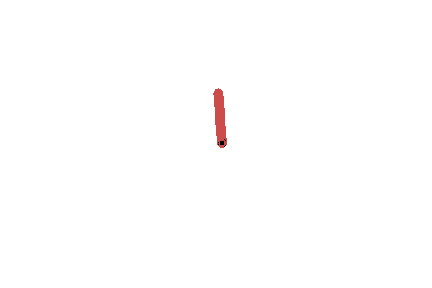
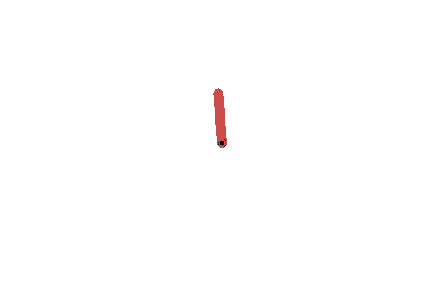
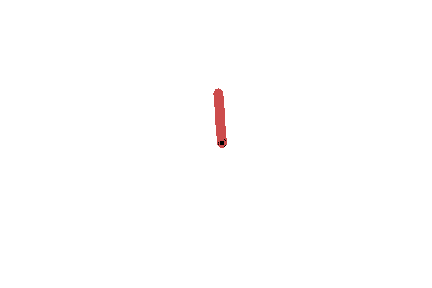
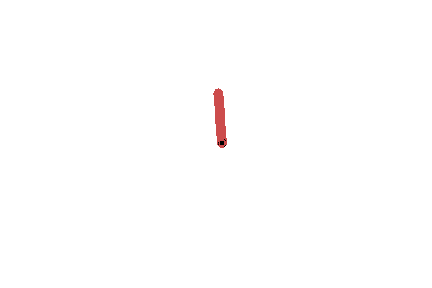
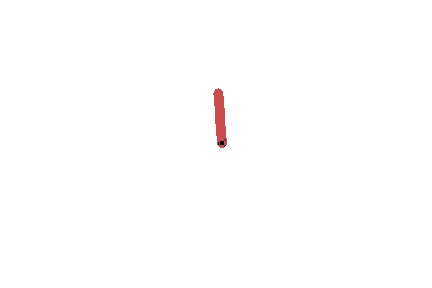
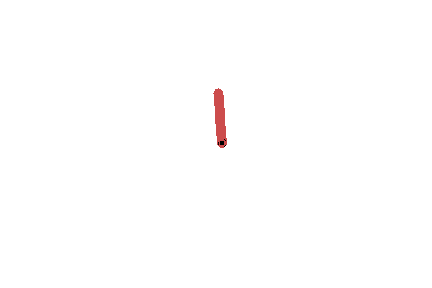
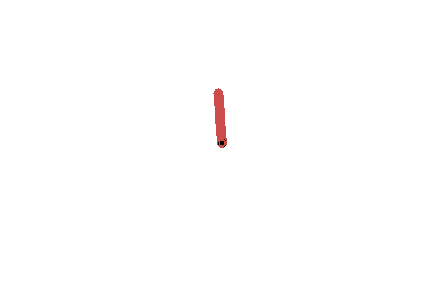
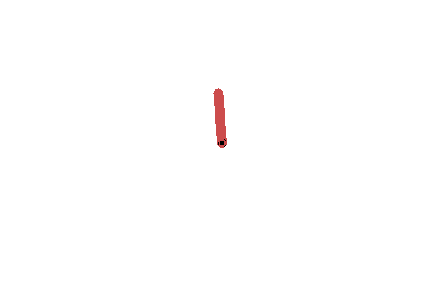
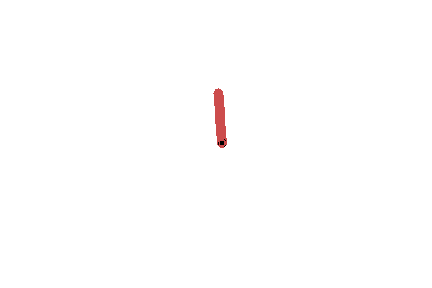
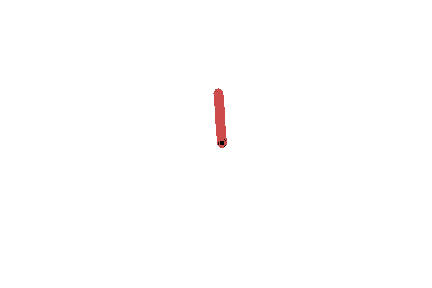
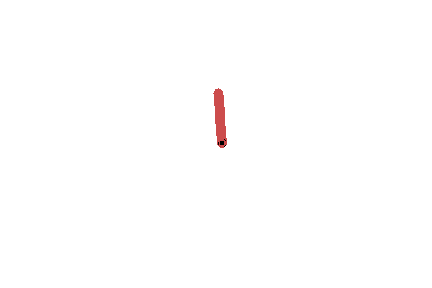
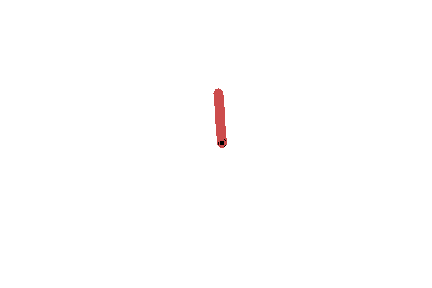
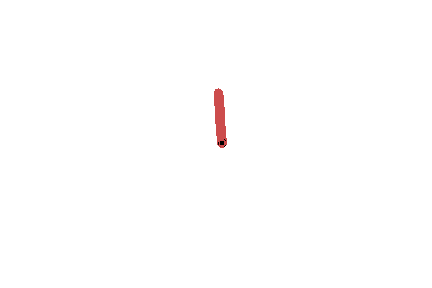
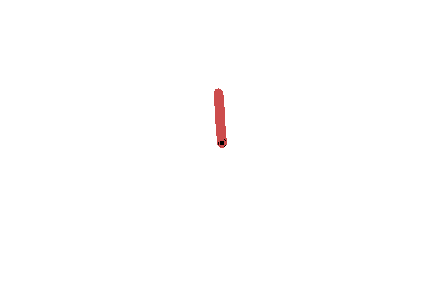
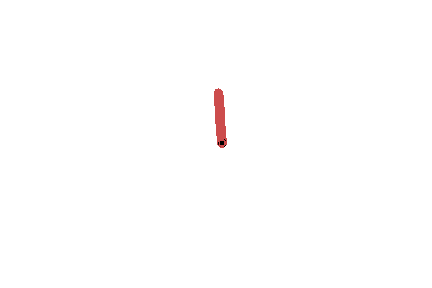
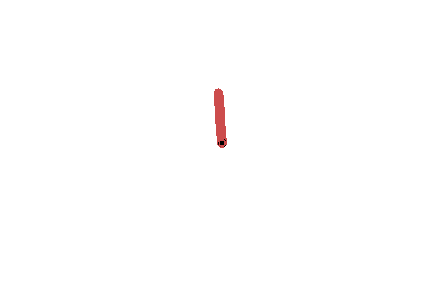
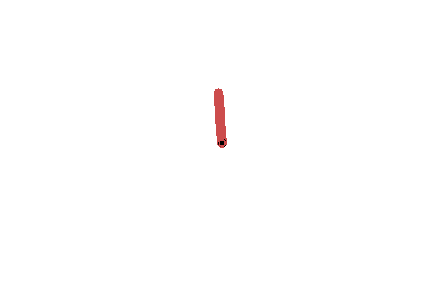
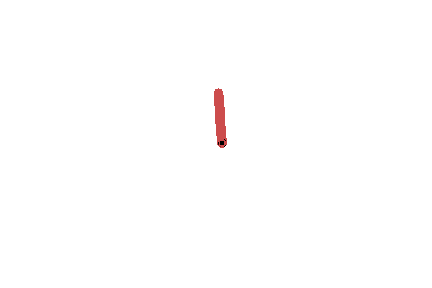
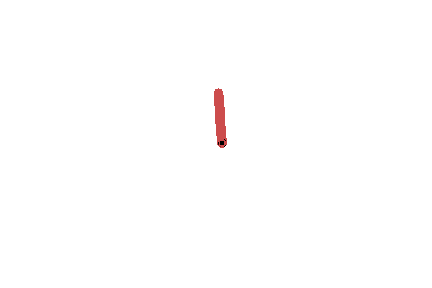
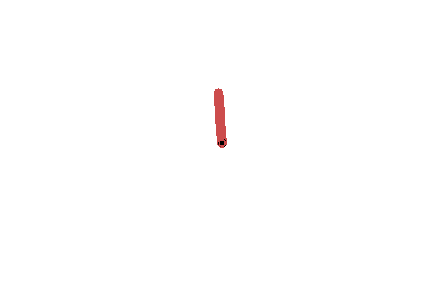
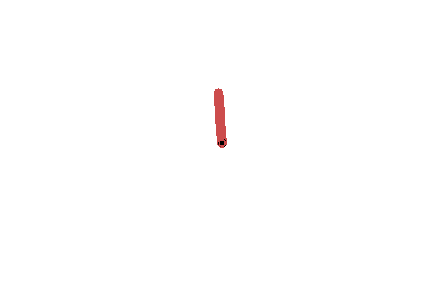
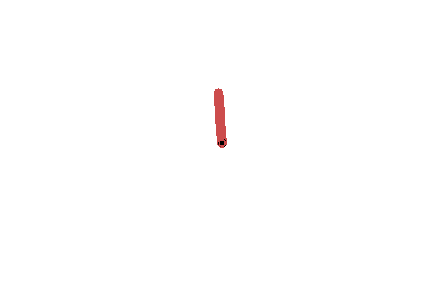
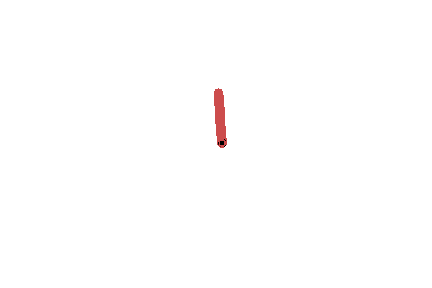
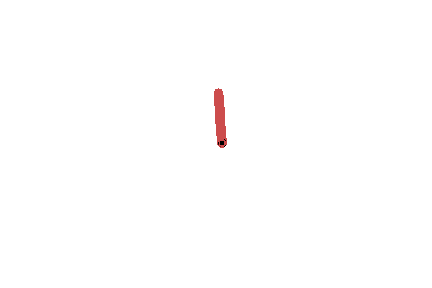
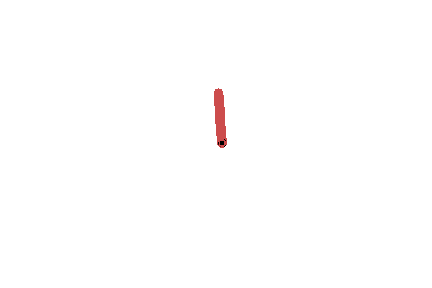
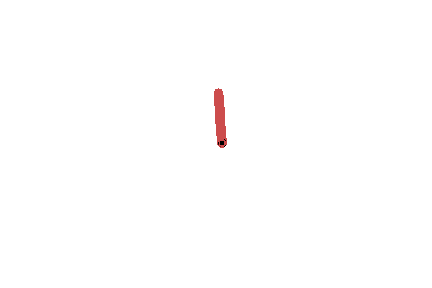
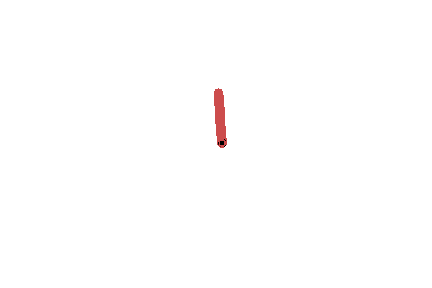
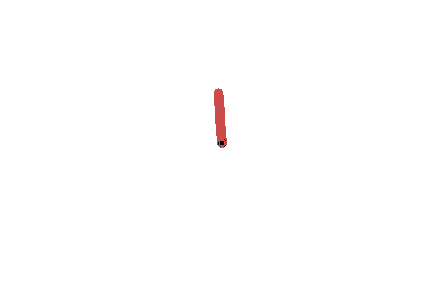
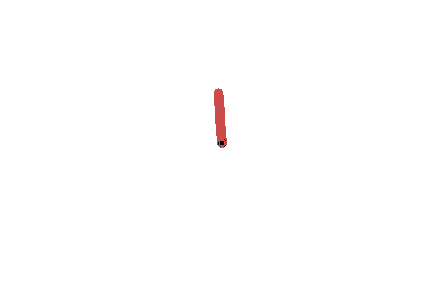
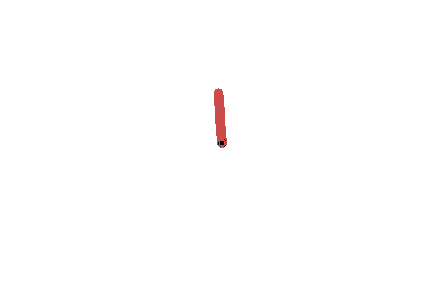
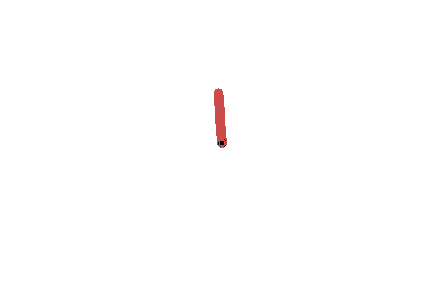
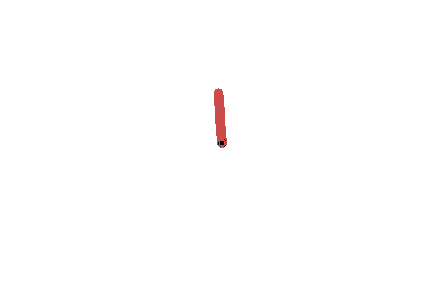
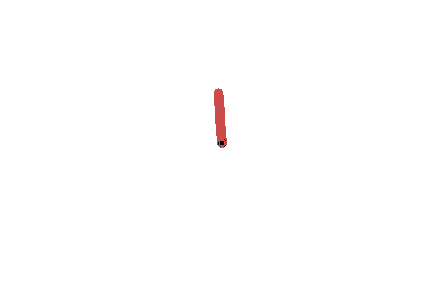
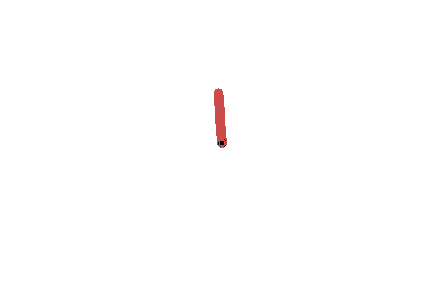
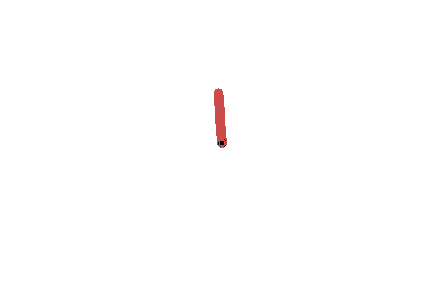
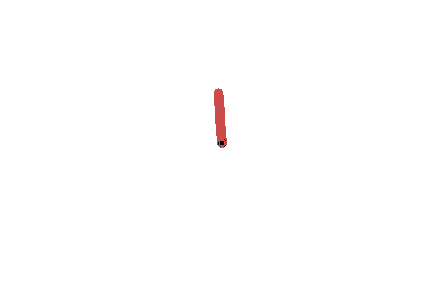
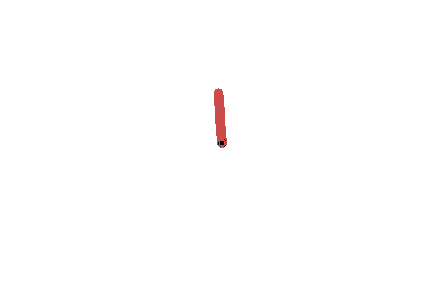
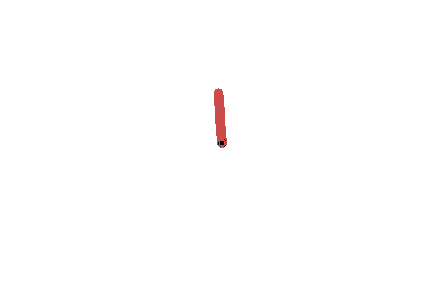
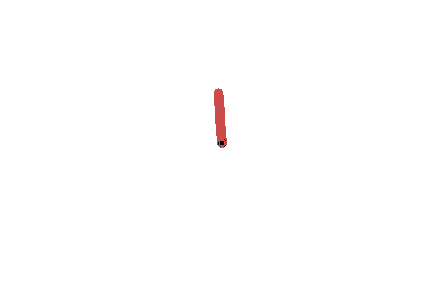
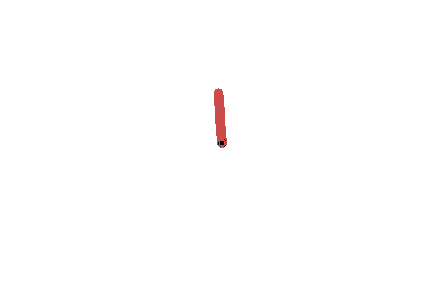
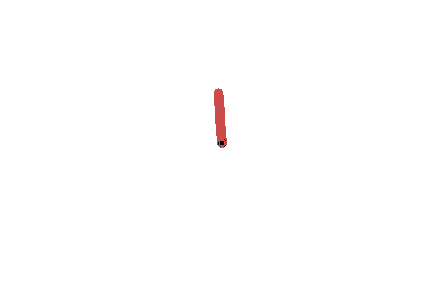
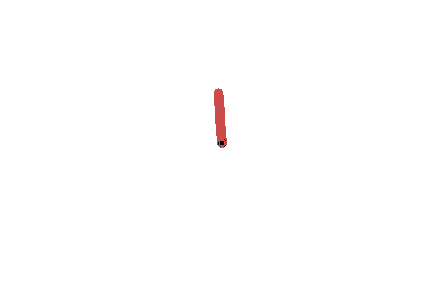
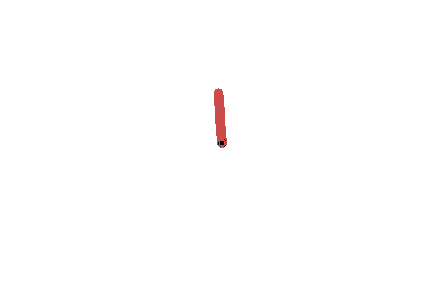
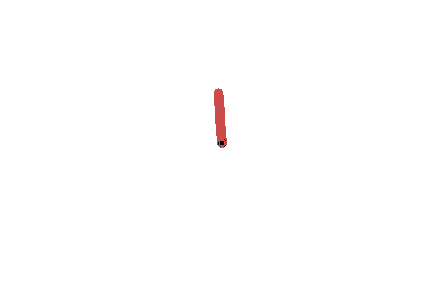
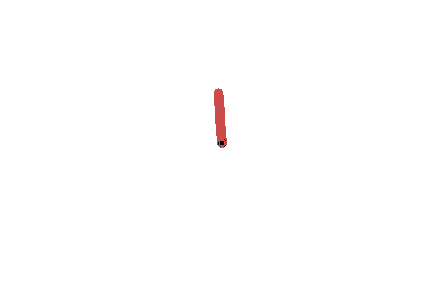
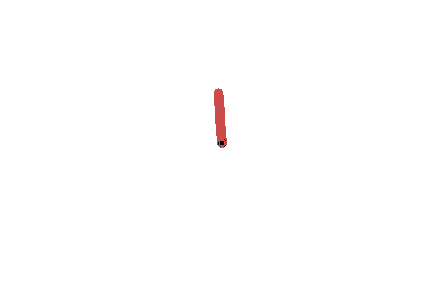
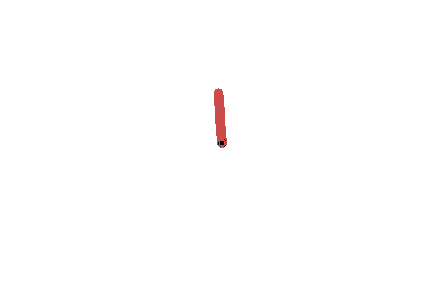
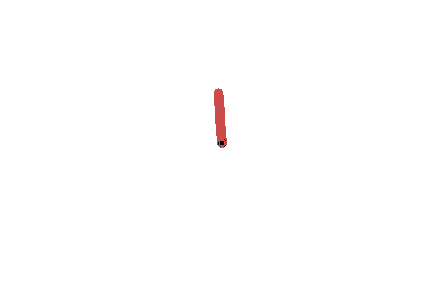
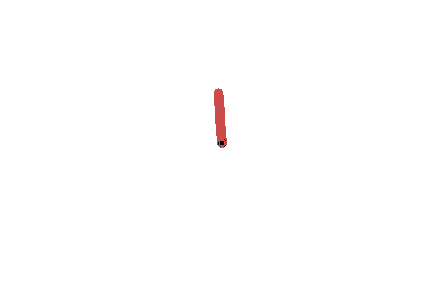
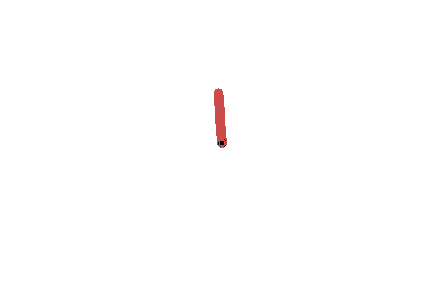
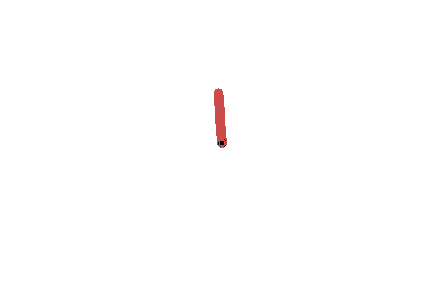
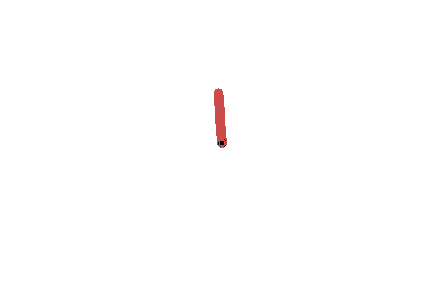
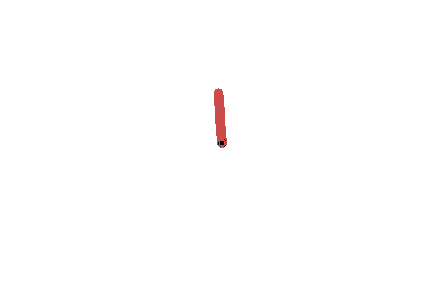
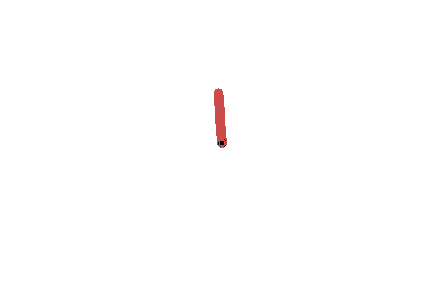
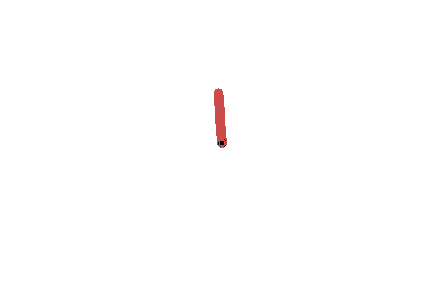
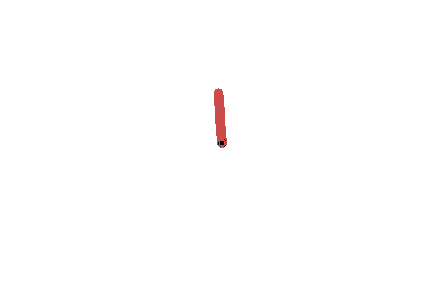
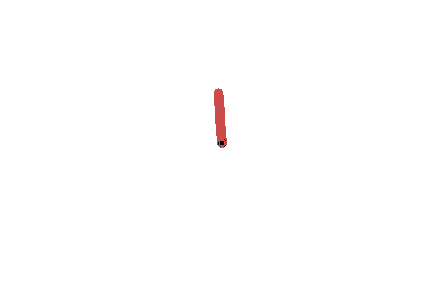
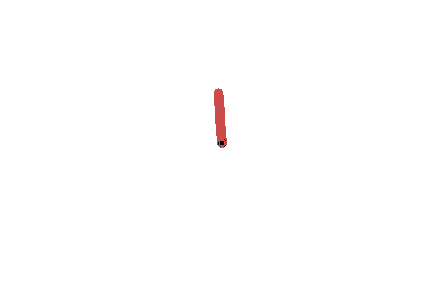
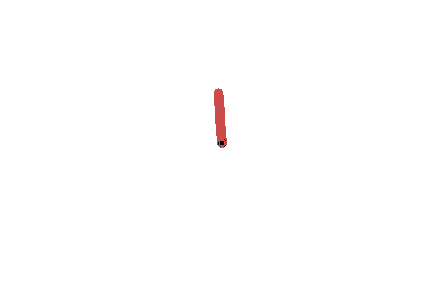
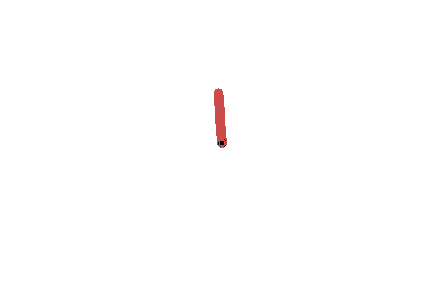
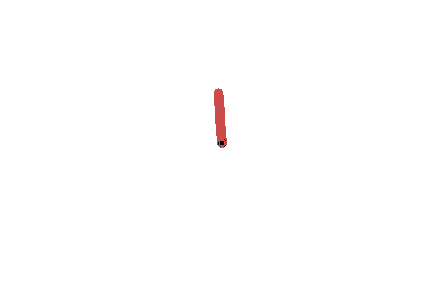
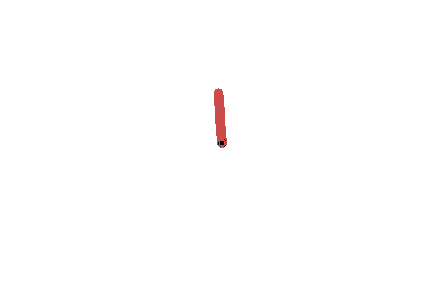
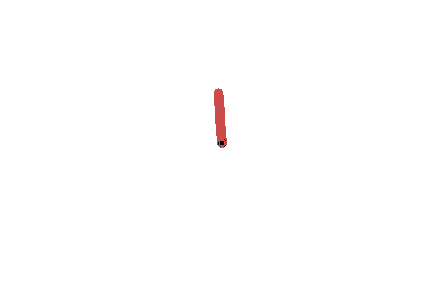
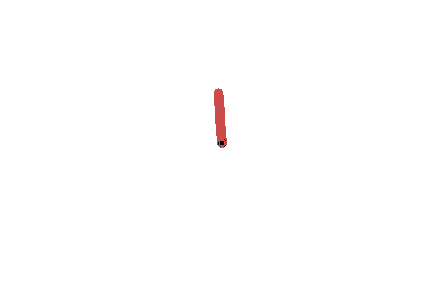
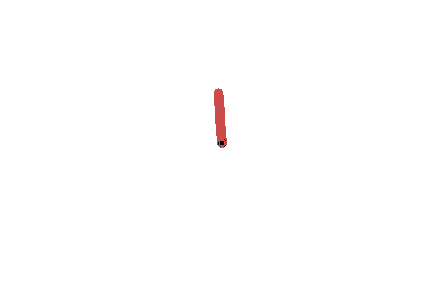
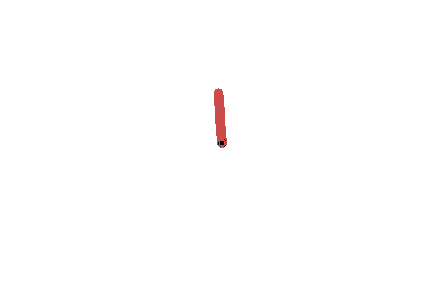
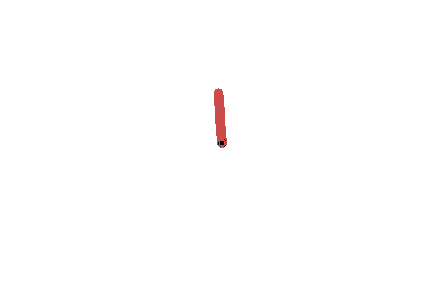
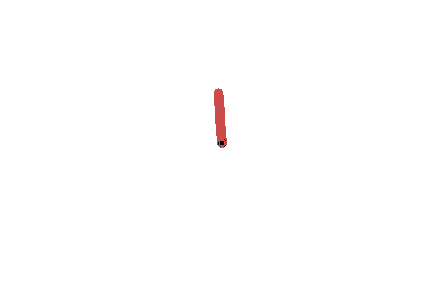
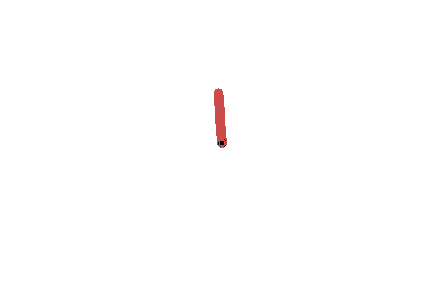
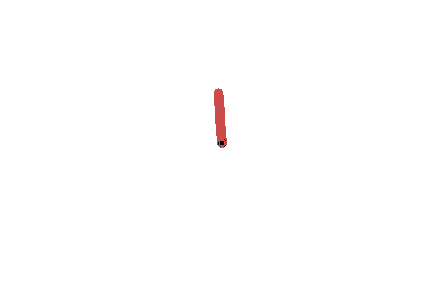
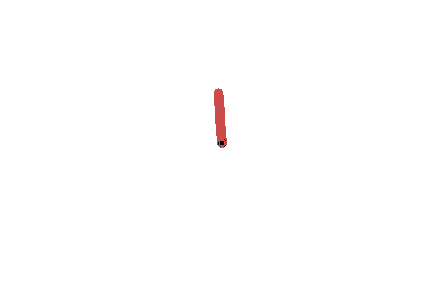
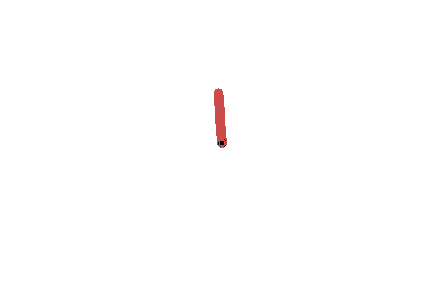
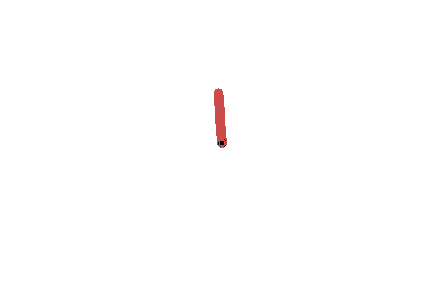
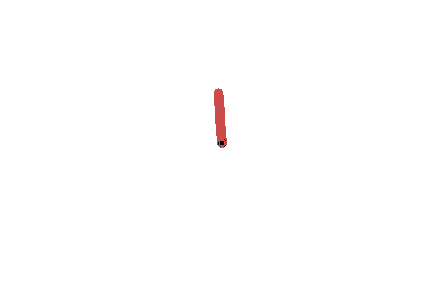
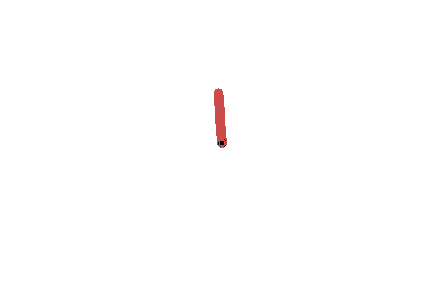
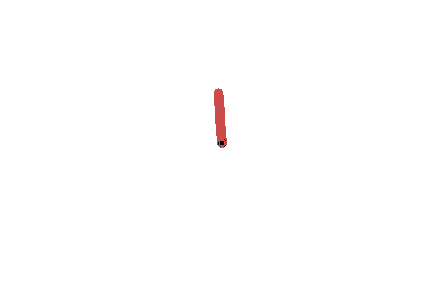
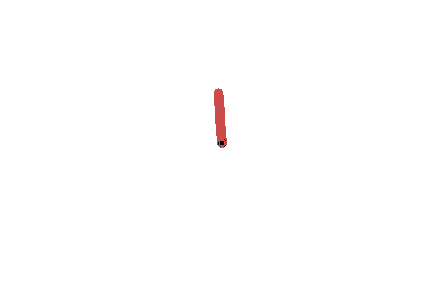
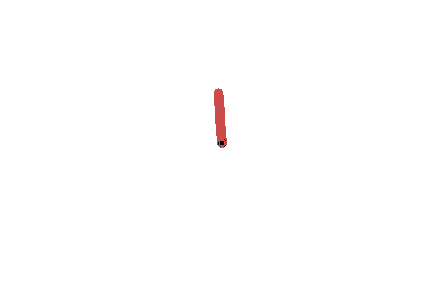
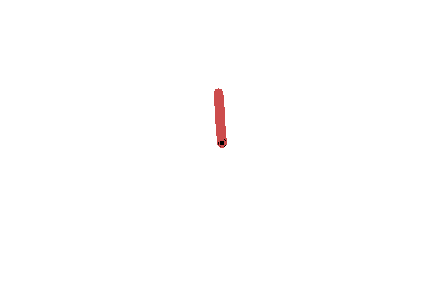
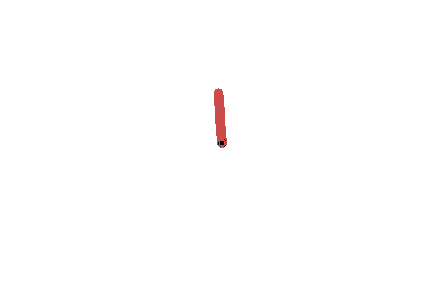
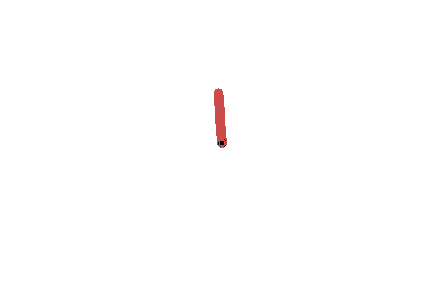
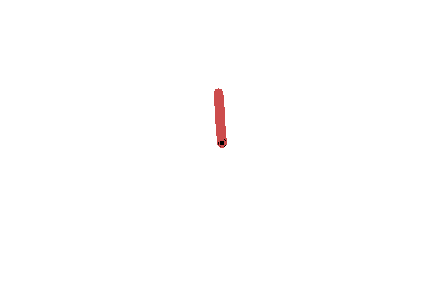
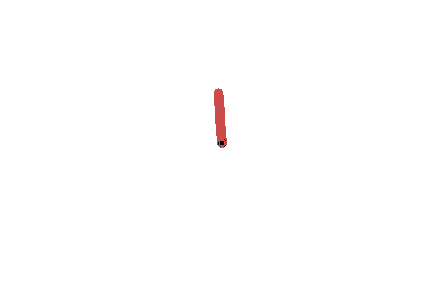
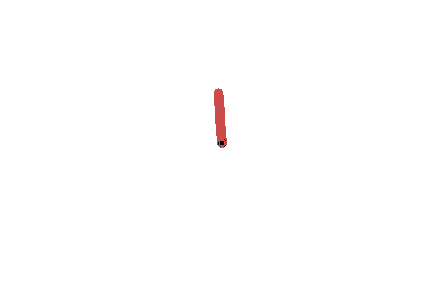
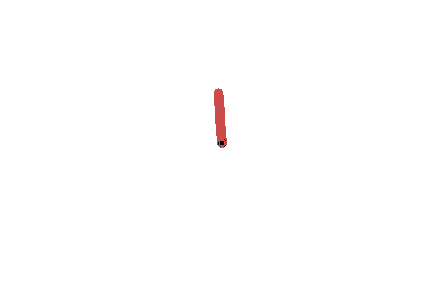
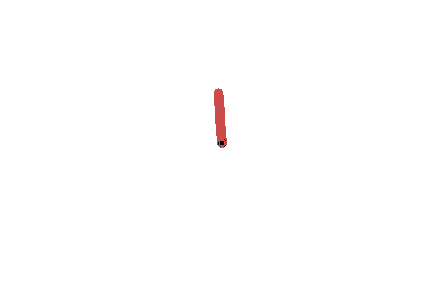
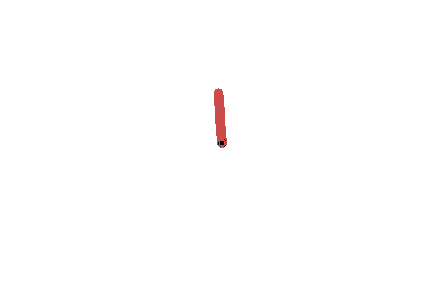
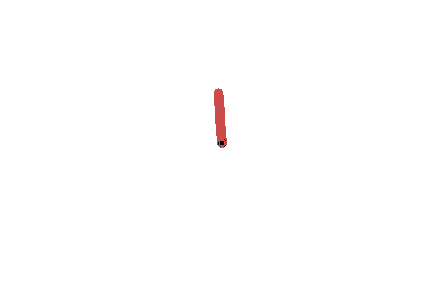
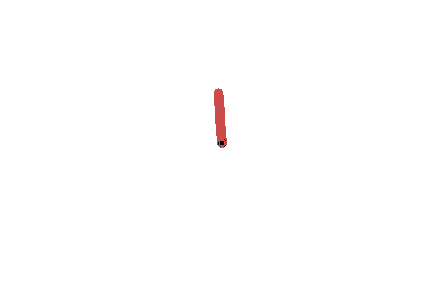
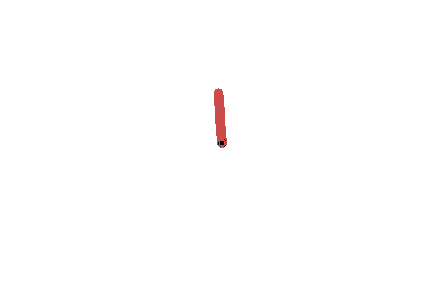
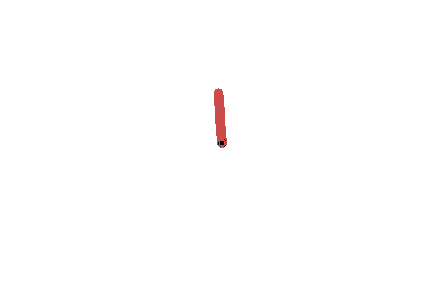
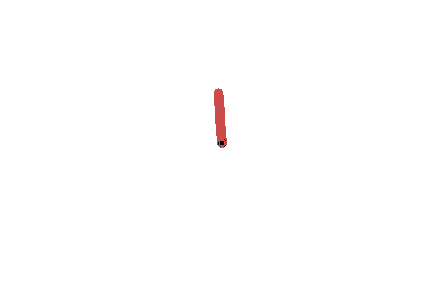
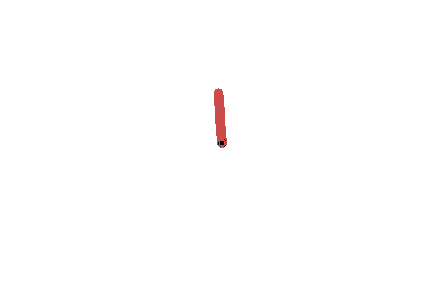
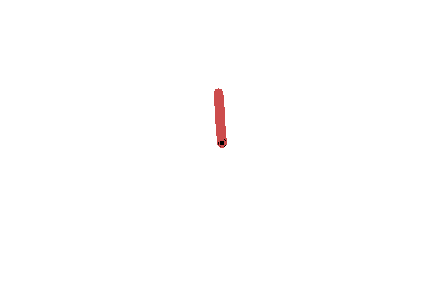
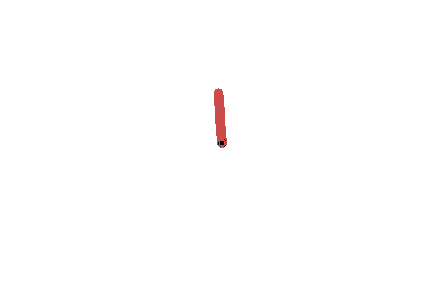
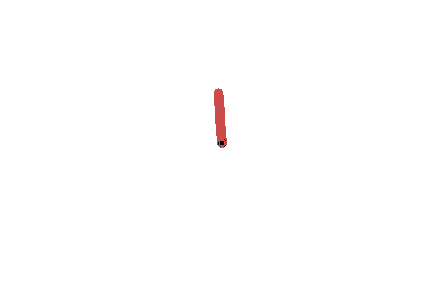
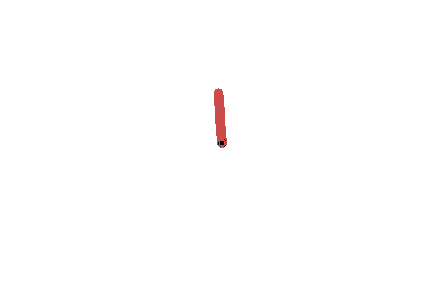
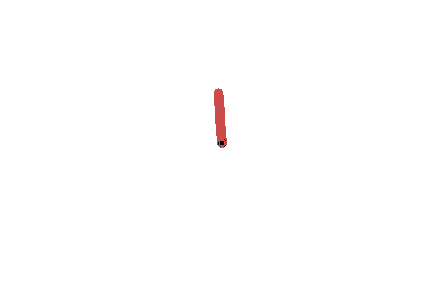
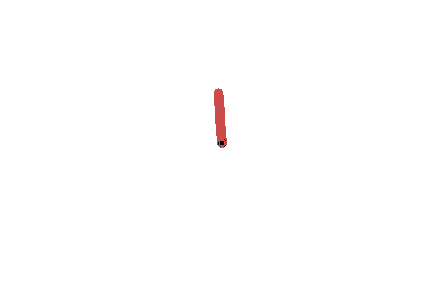
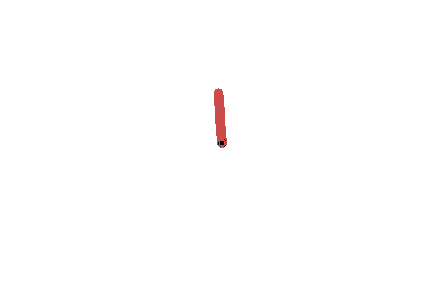
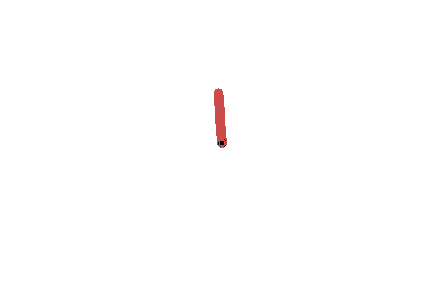
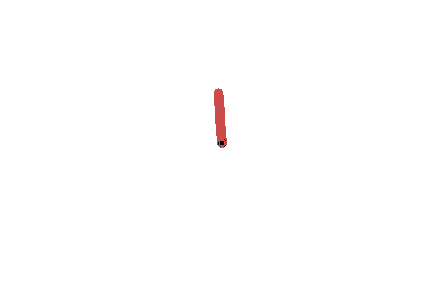
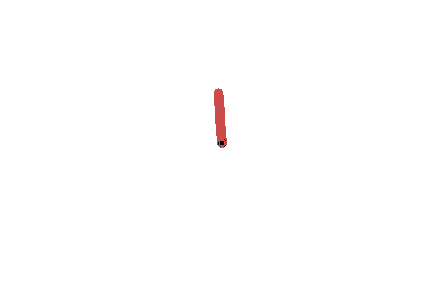
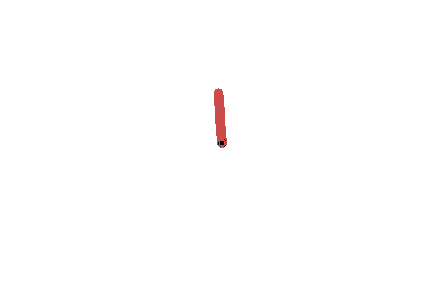
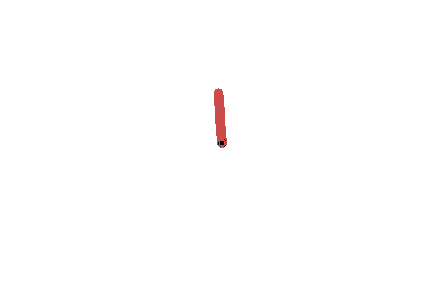
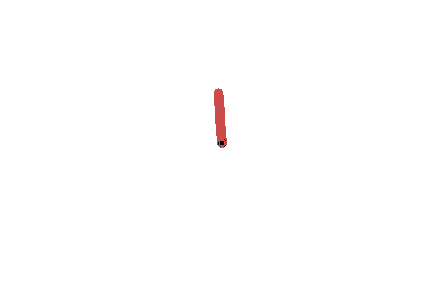
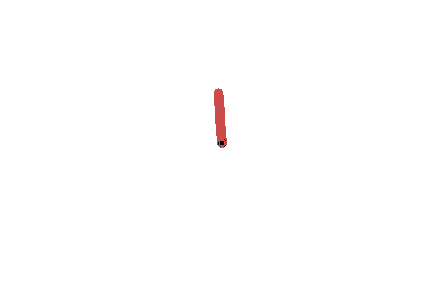
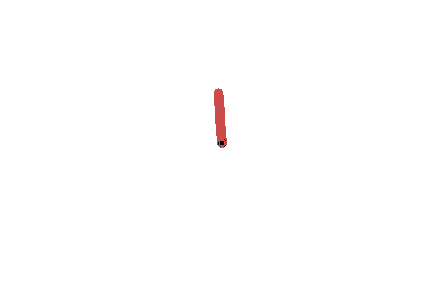
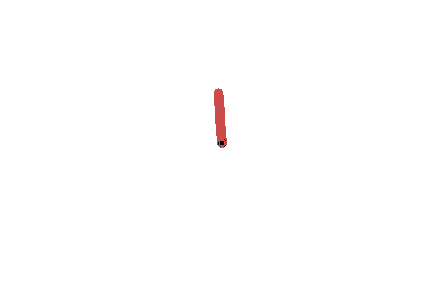
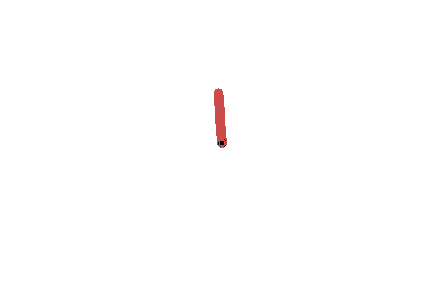
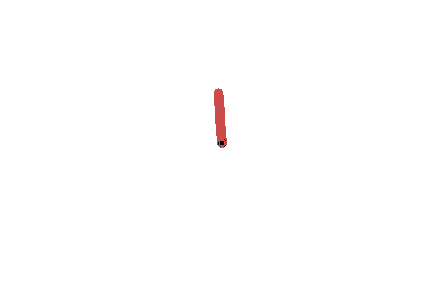
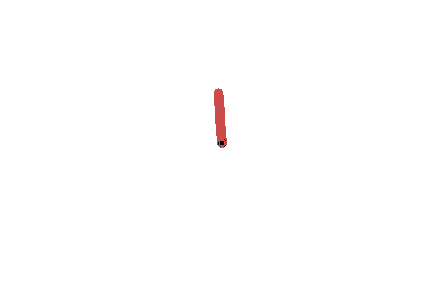
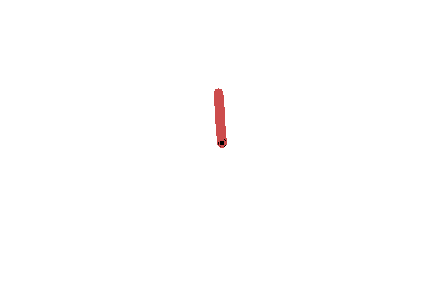
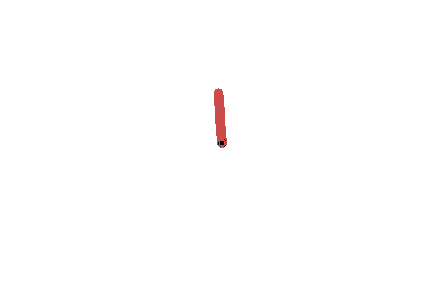
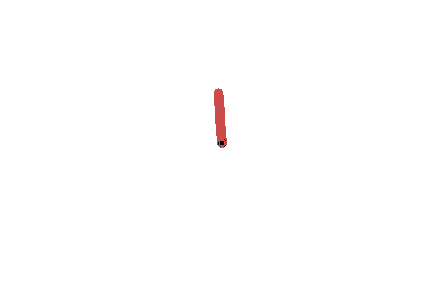
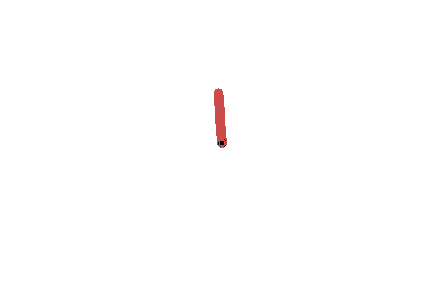
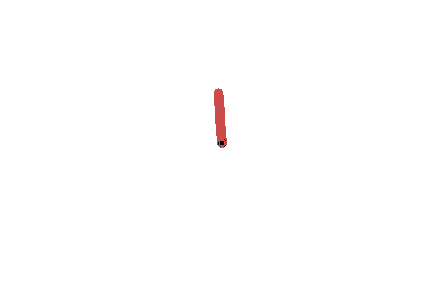

In [14]:
# Imports specifically so we can render outputs in Colab.
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display


def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    display(display_animation(anim, default_mode='loop'))
    
        
# display 
display_frames_as_gif(frames)